# Text Analysis Project

This script performs text analysis on a dataset stored in a CSV file. It leverages various Python libraries for data manipulation, natural language processing (NLP), visualization, and topic modeling.

---

## Prerequisites

Before running the script, ensure the following libraries are installed:

- **pandas**: For data manipulation and CSV handling.
- **os**: For file system operations (optional, depending on usage).
- **plotly.express**: For interactive visualizations.
- **matplotlib.pyplot**: For static plotting.
- **spacy**: For NLP tasks (requires model `en_core_web_sm`).
- **textblob**: For sentiment analysis.
- **wordcloud**: For generating word clouds.
- **scikit-learn**: For text vectorization and topic modeling.

Install dependencies using pip:
```bash
pip install pandas plotly matplotlib spacy textblob wordcloud scikit-learn

python -m spacy download en_core_web_sm

In [24]:
#Requirements
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from collections import defaultdict
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
nlp = spacy.load("en_core_web_sm")

In [25]:
# Loading Data
data = pd.read_csv("data/Text.csv", encoding='latin-1')
print(data.head())  # Display the first few rows of the dataset

                                             Article  \
0  Data analysis is the process of inspecting and...   
1  The performance of a machine learning algorith...   
2  You must have seen the news divided into categ...   
3  When there are only two classes in a classific...   
4  The Multinomial Naive Bayes is one of the vari...   

                                               Title  
0                  Best Books to Learn Data Analysis  
1         Assumptions of Machine Learning Algorithms  
2          News Classification with Machine Learning  
3  Multiclass Classification Algorithms in Machin...  
4        Multinomial Naive Bayes in Machine Learning  


# Let's create a Word-Cloud

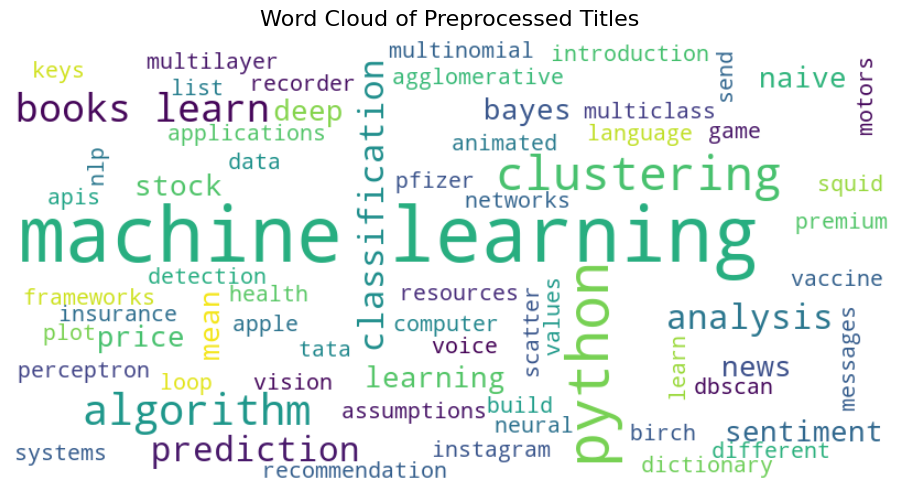

In [30]:

# Combine titles into a single string with preprocessing
def preprocess_text(text):
    doc = nlp(text)
    # Keep only meaningful tokens (no stopwords, punctuation, or numbers)
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]
    return " ".join(tokens)

# Join all titles and preprocess
all_titles = " ".join(data['Title'].dropna().astype(str).tolist())
cleaned_titles = preprocess_text(all_titles)

# Define custom stopwords (add domain-specific words if needed)
custom_stopwords = set(STOPWORDS).union({'example', 'title','Use', 'cases','types','swap','shift','items','best'})  # Add more as needed

# Generate word cloud with enhanced settings
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords,
    colormap='viridis',  # Color scheme for visual appeal
    max_words=100,       # Limit to top 100 words
    min_font_size=10     # Minimum font size for readability
).generate(cleaned_titles)

# Plot and save the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Preprocessed Titles", fontsize=16, pad=10)
plt.tight_layout()

# Save to file
wordcloud.to_file("assets/Results/wordcloud_titles.png")  # Saves as PNG in current directory
plt.show()

# Lets Perform Sentimental Analysis

In [27]:
# Sentiment Analysis
def get_sentiment(text):
    """Calculate sentiment polarity with error handling."""
    try:
        text = str(text) if pd.notna(text) else ""
        return TextBlob(text).sentiment.polarity
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.0  # Default to neutral

# Applying Sentiment Analysis
data['Sentiment'] = data['Article'].apply(get_sentiment)

# Categorizing Sentiment
def categorize_sentiment(polarity):
    """Categorize sentiment into Positive, Negative, or Neutral."""
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

data['Sentiment_Category'] = data['Sentiment'].apply(categorize_sentiment)

# Visualizing Sentiment
fig = px.histogram(
    data,
    x='Sentiment',
    nbins=20,
    title='Sentiment Analysis of Articles',
    labels={'Sentiment': 'Sentiment Polarity'},
    color='Sentiment_Category',
    color_discrete_map={'Positive': '#00CC96', 'Negative': '#EF553B', 'Neutral': '#636EFA'},
    marginal="rug"
)
fig.update_layout(
    xaxis_title='Sentiment Polarity (-1 to 1)',
    yaxis_title='Number of Articles',
    title_font=dict(size=20, family="Arial"),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-1, 1]),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    legend_title="Sentiment Category",
    bargap=0.1
)
fig.show()  

# Displaying Summary Statistics
display("Sentiment Summary:")
display(data['Sentiment'].describe())
display("\nSentiment Category Counts:")
display(data['Sentiment_Category'].value_counts())

'Sentiment Summary:'

count    34.000000
mean      0.160138
std       0.296732
min      -0.800000
25%       0.000000
50%       0.134464
75%       0.332299
max       0.666667
Name: Sentiment, dtype: float64

'\nSentiment Category Counts:'

Sentiment_Category
Positive    18
Neutral     11
Negative     5
Name: count, dtype: int64

# Lets work on Recognising Named Entities

In [28]:


# Extracting and Applying NER (Named Entities Recognition)

data['Entities'] = data['Article'].apply(lambda x: {ent.label_: ent.text for ent in nlp(str(x) if pd.notna(x) else "").ents})
display(data[['Article', 'Entities']].head())  # Preview

# Visualizing NER Results
def visualize_ner(entities_series, plot_type='types'):
    """Visualize NER results: 'types' for entity types, 'entities' for top individual entities."""
    counts = Counter()
    if plot_type == 'types':
        for entities in entities_series:
            counts.update(entities.keys())  # Count entity types
        title = 'Frequency of Named Entity Types in Articles'
        x_label = 'Entity Type'
    else:
        for entities in entities_series:
            counts.update(entities.values())  # Count individual entities
        title = 'Top 10 Named Entities in Articles'
        x_label = 'Named Entity'

    # Converting to DataFrame
    df = pd.DataFrame(counts.items(), columns=[x_label, 'Count'])
    df = df.sort_values(by='Count', ascending=False).head(10 if plot_type == 'entities' else None)

    # Plotting
    fig = px.bar(
        df,
        x=x_label,
        y='Count',
        title=title,
        labels={'Count': 'Frequency'},
        color='Count',
        color_continuous_scale='Viridis' 
    )
    fig.update_layout(
        yaxis_title='Frequency',
        title_font=dict(size=20, family="Arial"),
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        bargap=0.2
    )
    fig.show()

# Visualizations
visualize_ner(data['Entities'], plot_type='types')    # Entity types
visualize_ner(data['Entities'], plot_type='entities') # Top entities

,Article,Entities
0,Data analysis is the process of inspecting and...,{'DATE': 'today'}
1,The performance of a machine learning algorith...,{}
2,You must have seen the news divided into categ...,{}
3,When there are only two classes in a classific...,{'CARDINAL': 'more than two'}
4,The Multinomial Naive Bayes is one of the vari...,{'ORG': 'the Multinomial Naive Bayes'}


# Let perform Topic Modelling using LDA

In [29]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly.express as px

# Preprocess text and fit LDA 
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(
    data['Article'].dropna().apply(
        lambda x: " ".join([token.lemma_.lower() for token in nlp(str(x)) 
                           if not token.is_stop and not token.is_punct and not token.is_digit])
    )
)
lda = LDA(n_components=5, random_state=42).fit(dtm)

# Display and Visualize Topics
def show_lda_topics(model, vectorizer, num_words=10):
    """Display and visualize LDA topics."""
    # Extract top words for each topic
    topics = [", ".join([vectorizer.get_feature_names_out()[i] 
                        for i in topic.argsort()[-num_words:][::-1]]) 
              for topic in model.components_]
    
    # Print topics
    for idx, topic in enumerate(topics):
        print(f"Topic {idx + 1}: {topic}")

    # Visualize with Plotly
    fig = px.bar(
        x=[f'Topic {i+1}' for i in range(len(topics))],
        y=[i for i in range(len(topics))],
        text=topics,
        title='LDA Topics Visualization',
        labels={'x': 'Topics', 'text': 'Top Words'},
        color=[i for i in range(len(topics))],
        color_continuous_scale='Viridis'
    )
    fig.update_traces(textposition='outside')
    fig.update_layout(
        yaxis={'showgrid': False, 'title': 'Index'},
        xaxis={'title': 'Topics', 'showgrid': True, 'gridcolor': 'LightGray'},
        title_font={'size': 20, 'family': "Arial"},
        bargap=0.2
    )
    fig.show()

# Run the function
show_lda_topics(lda, vectorizer)

Topic 1: learn, python, insurance, application, machine, want, algorithm, assumption, tutorial, science
Topic 2: algorithm, python, learning, machine, classification, api, base, clustering, bayes, datum
Topic 3: analysis, sentiment, datum, want, learn, people, python, data, analyze, today
Topic 4: news, category, computer, learning, machine, website, good, know, popular, task
Topic 5: learning, machine, clustering, algorithm, stock, learn, language, deep, python, price
